In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/overview


fatal: destination path 'overview' already exists and is not an empty directory.


In [ ]:
!mv overview german-traffic-signs



mv: cannot move 'overview' to 'german-traffic-signs/overview': Directory not empty


In [ ]:
!ls german-traffic-signs/


overview  signnames.csv  test.p  train.p  valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2
import requests
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)

def unpickle_data():
  with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
  with open('german-traffic-signs/valid.p', 'rb') as f:
    validation_data = pickle.load(f)
  with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
  return train_data, validation_data, test_data

In [ ]:
train_data, validation_data, test_data = unpickle_data()
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = validation_data['features'], validation_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of training images is different from the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of validation images is different from the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of test images is different from the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The training images are not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3)), "The training images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "The training images are not 32x32x3"

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

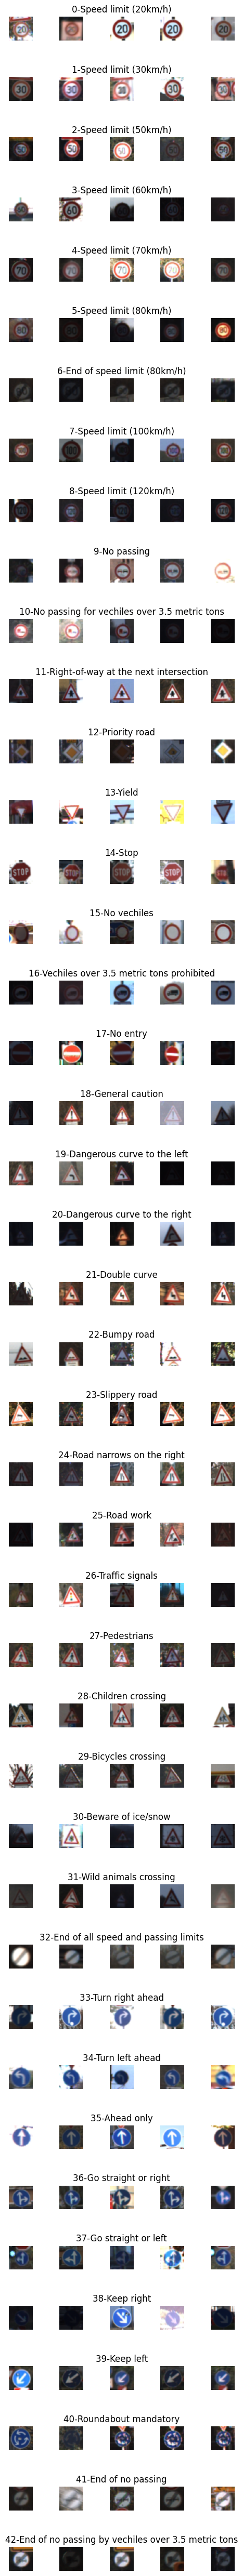

In [ ]:
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      num_of_samples.append(len(x_selected))
      axs[j][i].set_title(str(j) + "-" + row["SignName"])


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

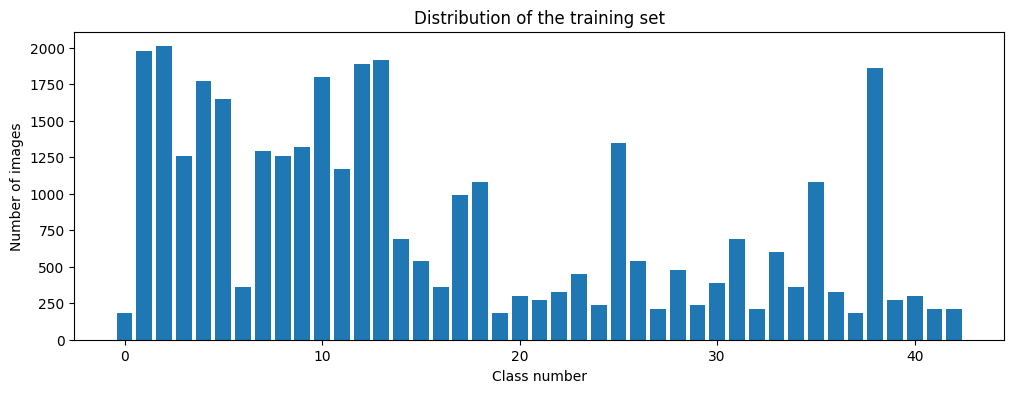

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training set")
plt.xlabel("Class number")
plt.ylabel("Number of images")


(32, 32, 3)
36


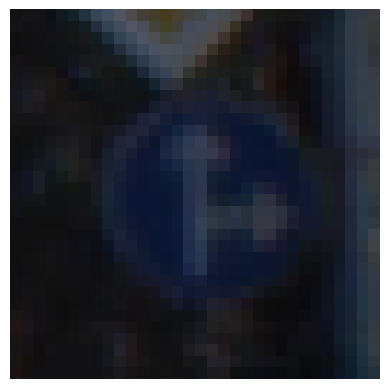

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

(32, 32)


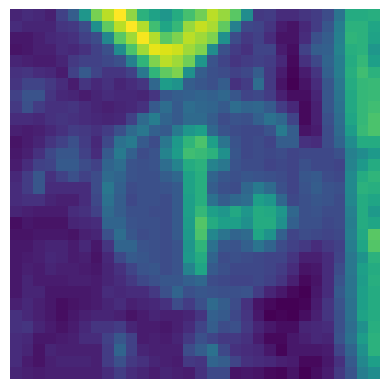

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
# Histogram equalization aims to standardise the lighting in all images, enhances contrast
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

(32, 32)


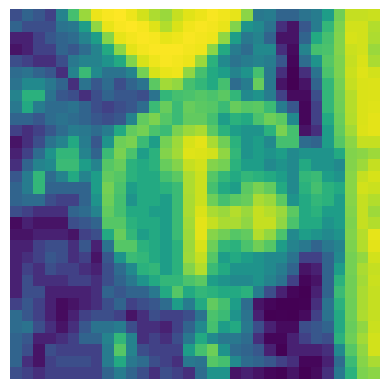

In [ ]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


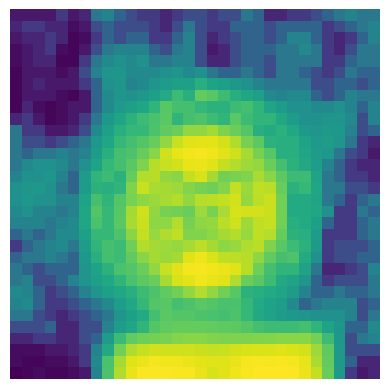

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range=10)
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

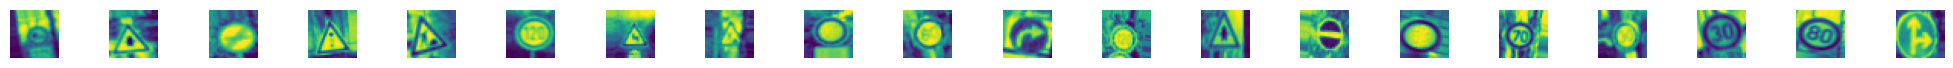

In [ ]:
fig, axs = plt.subplots(1, 20, figsize=(20, 5))
fig.tight_layout()
for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = leNet_model()
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 12, 12, 30)        16230     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 6, 6, 30)          0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 1080)              0         
                                                                 
 dense_36 (Dense)            (None, 500)             

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_57 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 12, 12, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_59 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 4, 4, 30)          0         
 ng2D)                                               

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=X_train.shape[0]/50, epochs=15, validation_data=(X_val, y_val), verbose=1, shuffle=1)

Epoch 1/15
695/695 [==============================] - 17s 22ms/step - loss: 1.8132 - accuracy: 0.4873 - val_loss: 0.3814 - val_accuracy: 0.8859
Epoch 2/15
695/695 [==============================] - 15s 21ms/step - loss: 0.5943 - accuracy: 0.8176 - val_loss: 0.1796 - val_accuracy: 0.9510
Epoch 3/15
695/695 [==============================] - 15s 22ms/step - loss: 0.3645 - accuracy: 0.8858 - val_loss: 0.1169 - val_accuracy: 0.9687
Epoch 4/15
695/695 [==============================] - 15s 21ms/step - loss: 0.2846 - accuracy: 0.9115 - val_loss: 0.0916 - val_accuracy: 0.9705
Epoch 5/15
695/695 [==============================] - 17s 25ms/step - loss: 0.2200 - accuracy: 0.9312 - val_loss: 0.0796 - val_accuracy: 0.9769
Epoch 6/15
695/695 [==============================] - 15s 21ms/step - loss: 0.1812 - accuracy: 0.9441 - val_loss: 0.0703 - val_accuracy: 0.9810
Epoch 7/15
695/695 [==============================] - 15s 22ms/step - loss: 0.1712 - accuracy: 0.9468 - val_loss: 0.0653 - val_accuracy:

Text(0.5, 0, "'epoch")

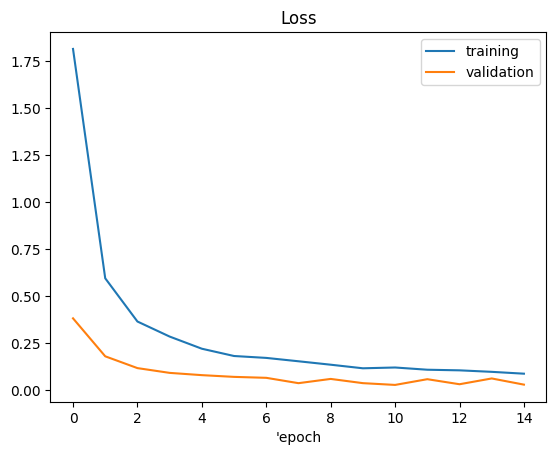

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("'epoch")

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

395/395 [==============================] - 2s 4ms/step - loss: 0.1391 - accuracy: 0.9702
Test score:  0.13913197815418243
Test accuracy:  0.9702296257019043


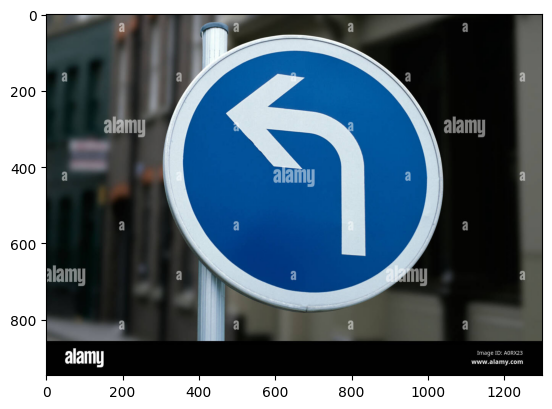

In [ ]:
#url = "https://c8.alamy.com/comp/G667W0/road-sign-speed_limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-mits-turn-left-sign-A0RX23.jpg"
#url = "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))



In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
img = img.reshape(1, 32, 32, 1)
print("Predicted sign: " + str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 20ms/step
Predicted sign: [34]
